In [1]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

In [2]:
##### Function visualizes a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
##### Function shows the model predictions
def visualize_results(model, classnames, num_images=6):
    plt.ion()
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            indx = list(range(inputs.size()[0]))
            shuffle(indx)
            for j in indx:
                images_so_far += 1
                title = 'Image {}: class <{}> predicted <{}>'.format(j, classnames[labels[j]], classnames[preds[j]])
                imshow(inputs.cpu().data[j], title)
                plt.pause(2.5)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)
        plt.close()

In [4]:
##### Function for training and evaluate a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    r"""	Support function for model training.
    Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    Return:
    model: most accurate model at accuracy meassure
    <list>: epoch number iterations
    <<list>,<list>>: training loss and accuracy iterations
    <<list>,<list>>: val loss and accuracy iterations
    """

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_lst = []
    trn_loss_lst = []
    trn_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # save training val metadata metrics
            if phase == 'train':
            	epoch_lst.append(epoch)
            	trn_loss_lst.append(np.round(epoch_loss, 4))
            	trn_acc_lst.append(np.round(epoch_acc.cpu().item(), 4))
            elif phase == 'val':
            	val_loss_lst.append(np.round(epoch_loss, 4))
            	val_acc_lst.append(np.round(epoch_acc.cpu().item(), 4))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    trn_metadata = [trn_loss_lst, trn_acc_lst]
    val_metadata = [val_loss_lst, val_acc_lst]

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_lst, trn_metadata, val_metadata

In [5]:
##### Plot training-validation metadata metrics
def draw_metric(iters, trn_list, val_list, title):
    plt.plot(iters, trn_list, '-b', label='train')
    plt.plot(iters, val_list, '-r', label='val')

    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image and clean plot
    plt.savefig(os.path.join(title+".png"))
    plt.clf()

In [6]:
################ Hyperparameters ################
# Path where dataset is stored
dataset_dir = 'Galaxy10'

training_epochs = 10
schedule_steps = 5
learning_rate = 0.001
batch_size = 64

In [7]:
######## Data preparation ########

# Data augmentation
# Artificial data generation from original data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Helper for reading dataset folders
image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Helper that handle folder reader: folders [train, test]
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('Loaded dataset partitions size:', dataset_sizes)
print('Loaded dataset classes:', class_names)

Loaded dataset partitions size: {'train': 17428, 'val': 4357}
Loaded dataset classes: ['Disk-Edge_on-Boxy_Bulge', 'Disk-Edge_on-No_Bulge', 'Disk-Edge_on-Rounded_Bulge', 'Disk-Face_on-Loose_Spiral', 'Disk-Face_on-Medium_Spiral', 'Disk-Face_on-No_Spiral', 'Disk-Face_on-Tight_Spiral', 'Smooth-Cigar_shaped', 'Smooth-Completely-round', 'Smooth-in_between-round']


In [8]:
# Device for the computational load
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
# Select one model initialization only:
    # TRAINING FROM SCRATCH
    # TRANSFER LEARNING AND FINE TUNNING

In [12]:
# TRAINING FROM SCRATCH

# Model initialization (first time required download)
model_ft = models.resnet50(pretrained=False)

model_ft = model_ft.to(device)

In [10]:
# TRANSFER LEARNING AND FINE TUNNING from ImageNet

# Model initialization
model_ft = models.resnet50(pretrained=True)
# Finetunning and freeze as fixed feature extractor
for param in model_ft.parameters():
    param.requires_grad = False
    
# Create a new layer module for classification (requires_grad=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

In [13]:
# Optimization Loss function
criterion = nn.CrossEntropyLoss()

# Parameters and optimization rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every <schedule_steps> epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=schedule_steps, gamma=0.1)

----------
Epoch 1/10
train Loss: 1.8072 Acc: 0.3216
val Loss: 1.5149 Acc: 0.4168
----------
Epoch 2/10
train Loss: 1.4941 Acc: 0.3986
val Loss: 1.4011 Acc: 0.4563
----------
Epoch 3/10
train Loss: 1.4090 Acc: 0.4305
val Loss: 1.2993 Acc: 0.4884
----------
Epoch 4/10
train Loss: 1.3576 Acc: 0.4427
val Loss: 1.2828 Acc: 0.4639
----------
Epoch 5/10
train Loss: 1.3021 Acc: 0.4654
val Loss: 1.2167 Acc: 0.4891
----------
Epoch 6/10
train Loss: 1.2175 Acc: 0.5107
val Loss: 1.0932 Acc: 0.5678
----------
Epoch 7/10
train Loss: 1.1890 Acc: 0.5285
val Loss: 1.0785 Acc: 0.5717
----------
Epoch 8/10
train Loss: 1.1766 Acc: 0.5260
val Loss: 1.0658 Acc: 0.5809
----------
Epoch 9/10
train Loss: 1.1617 Acc: 0.5344
val Loss: 1.0773 Acc: 0.5616
----------
Epoch 10/10
train Loss: 1.1626 Acc: 0.5312
val Loss: 1.0547 Acc: 0.5775
Training complete in 11m 30s
Best val Acc: 0.580904


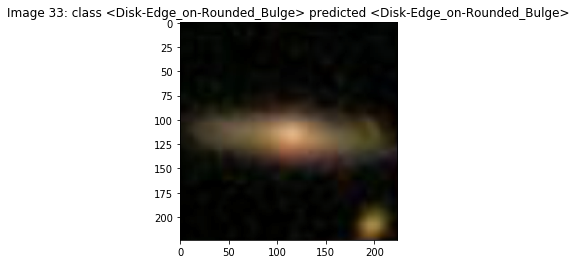

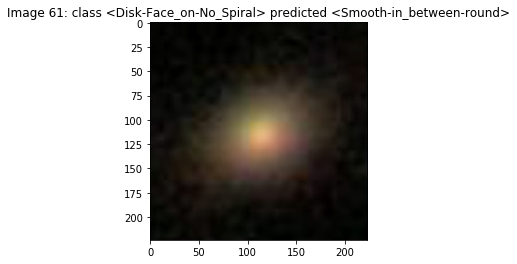

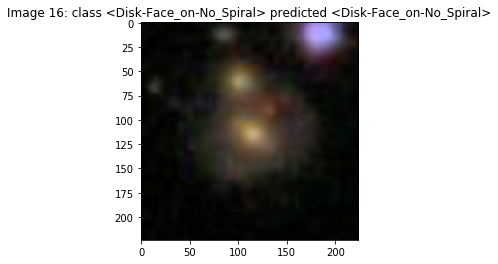

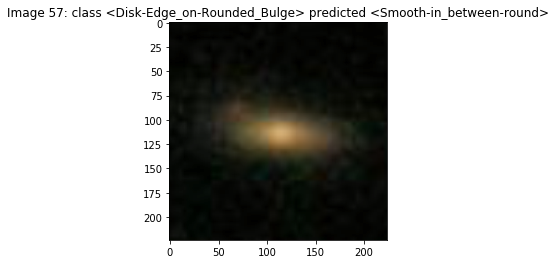

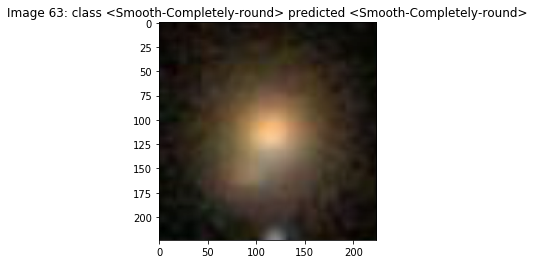

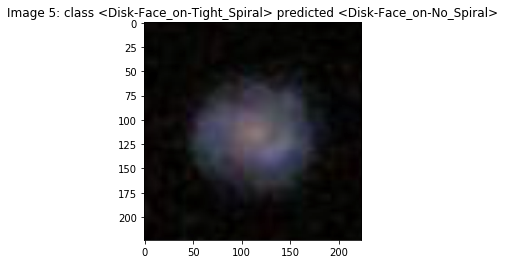

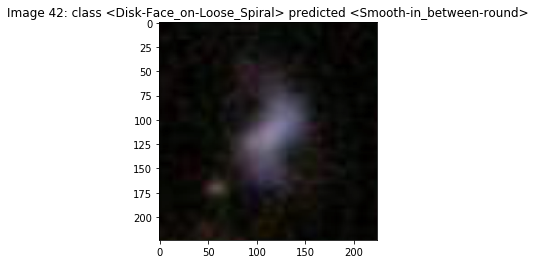

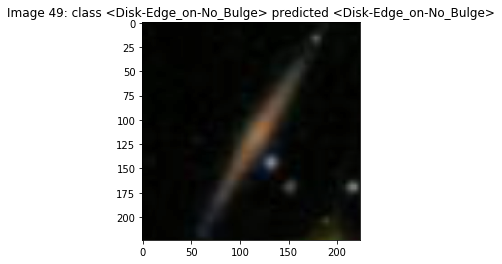

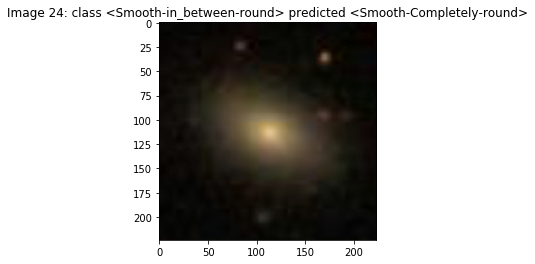

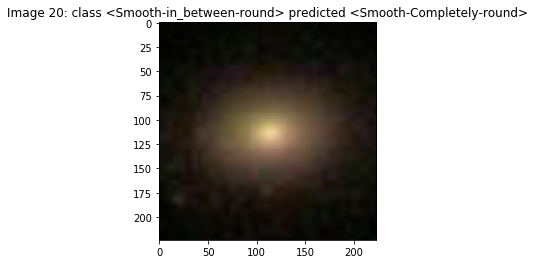

In [16]:
# Training and evaluation
model_ft, epc, trn, val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                                      num_epochs=training_epochs)

# model_ft is the best trained model
visualize_results(model_ft, class_names, num_images=6)

In [17]:
# Plot loss and accuracy metric in graphics
draw_metric(epc, trn[0], val[0], 'ResNet50_Galaxy10_Loss')
draw_metric(epc, trn[1], val[1], 'ResNet50_Galaxy10_Accuracy')

<Figure size 432x288 with 0 Axes>

In [18]:
# Save model in file for future inference
path = 'resnet50_galaxy10.pth'
torch.save(model_ft.state_dict(), path)

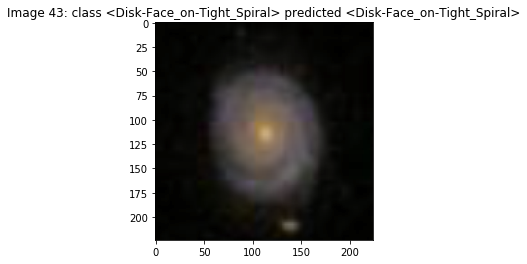

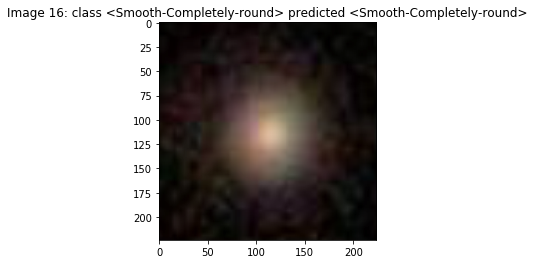

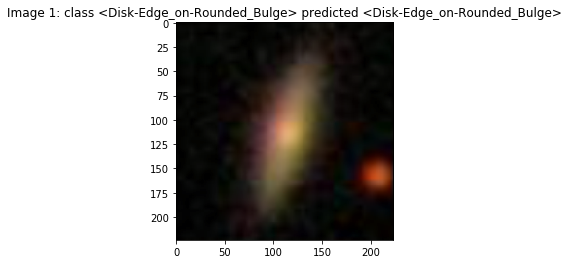

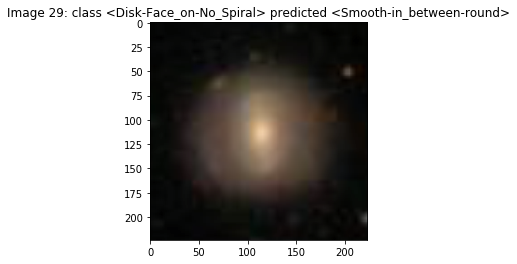

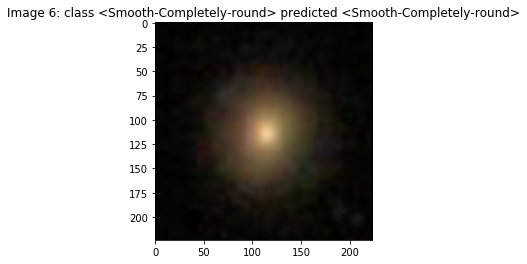

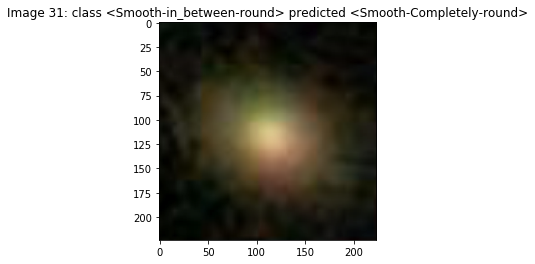

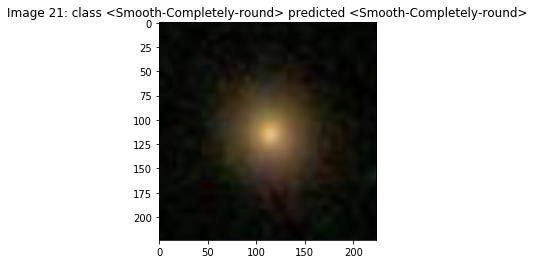

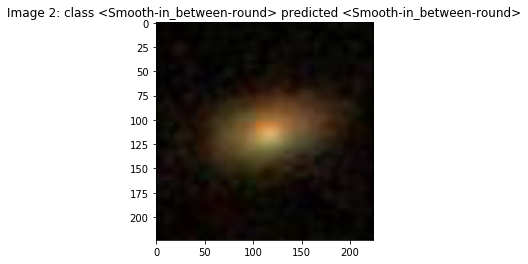

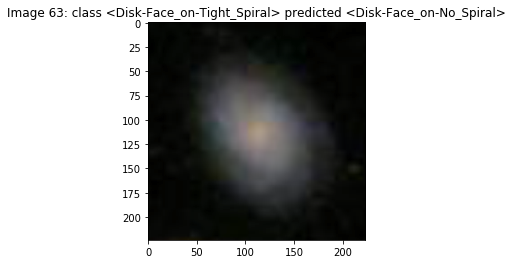

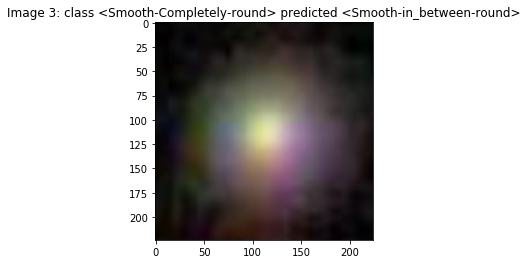

In [14]:
# INFERENCE LOADING PRETRAINED MODEL
# Load model and perform inference
path = 'resnet50_galaxy10.pth'
model_ft.load_state_dict(torch.load(path))

# Show some results
visualize_results(model_ft, class_names, num_images=10)